In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pathpy as pp
import random
from enum import Enum

### 1. $k$-regular random graphs

In [45]:
def generate_k_regular_random_graph(n_max: int, k: int) -> pp.Network:
    degree_sequence = [1]
    while not pp.generators.is_graphic_Erdos_Gallai(degree_sequence):
        degree_sequence = [k for _ in range(random.randint(1, n_max))]
    return pp.generators.Molloy_Reed(degree_sequence)


In [48]:
ks = np.arange(1,5)
max_nodes = 1000
num_samples = 5
avg_giant_component_size = np.zeros_like(ks)
for i, k in enumerate(ks):
    current = []
    for _ in range(num_samples):
        net = generate_k_regular_random_graph(max_nodes, k)
        current += [net.largest_component_size() / net.number_of_nodes()]
    avg_giant_component_size[i] = np.mean(current)

[0 0 1 1]


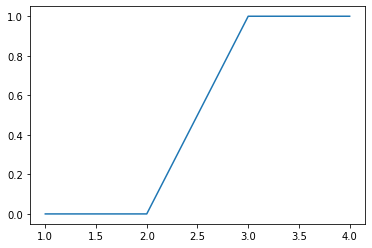

In [52]:
plt.plot(ks, avg_giant_component_size)

The plot above agrees with the analytical prediction of a giant connected component emerging iff $K > 2$.

### 2. Epidemic spreading in complex networks

In [4]:
class State(Enum):
    SUSCEPTIBLE = 1,
    INFECTED = 2

In [20]:
def simulate_sis_step(net: pp.Network, transmissablility: float):
    for v in net.nodes:
        if v.state == State.INFECTED:
            v.state = State.SUSCEPTIBLE
        else:
            is_neighborhood_infected = any(map(lambda u: u.state == State.INFECTED, net.neighbors[v.uid]))
            should_infect = random.uniform(0, 1) < transmissablility
            if is_neighborhood_infected and should_infect:
                v.state = State.INFECTED


In [21]:
def generate_sis_erdos_renyi(n: int, p: float, intial_infection: int) -> pp.Network:
    net = pp.generators.ER_np(n=n,p=p)
    for v in net.nodes:
        v.state = State.SUSCEPTIBLE
    shuffle = list(net.nodes)
    random.shuffle(shuffle)
    for v in shuffle[:intial_infection]:
        v.state = State.INFECTED
    
    return net

In [22]:
def plot_infection_graph(net: pp.Network):
    for v in net.nodes:
        if v.state == State.INFECTED:
            v["color"] = "red"
        else:
            v["color"] = "blue"
    net.plot()

In [28]:
def number_of_infected_nodes(net: pp.Network) -> int:
    infected = 0
    for v in net.nodes:
        if v.state == State.INFECTED:
            infected += 1
    return infected

In [32]:
def simulate_sis(net: pp.Network, steps: int, transmissability: float):
    for _ in range(steps):
        simulate_sis_step(net, transmissability)

### a)
We simulate the spreading of a disease with transmissability $\lambda \in \{0.1,0.2,\dots,0.9\}$ in a random Erdos-Renyi microstate with $n = 1000$ and $p = 0.003$. <br/>
(This may take a while. Reduce *num_samples* for lower runtimes.)

In [41]:
num_samples = 1
intial_infections = 10
transmissability = np.linspace(0.1,0.9,9)
infected_nodes = np.zeros_like(transmissability)
for i,l in enumerate(transmissability):
    current = []
    for _ in range(num_samples):
        net = generate_sis_erdos_renyi(1000,0.003, intial_infections)
        simulate_sis(net, 200, l)
        current += [number_of_infected_nodes(net)]
    infected_nodes[i] = np.mean(current)

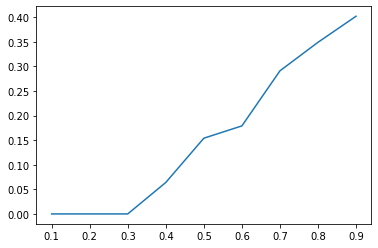

In [42]:
plt.plot(transmissability, infected_nodes / 1000)

### b)

In [43]:
num_samples = 1
intial_infections = 10
transmissability = 1/3.
probs = np.linspace(0.001, 0.005, 5)
infected_nodes = np.zeros_like(probs)
for i,p in enumerate(probs):
    current = []
    for _ in range(num_samples):
        net = generate_sis_erdos_renyi(1000,p, intial_infections)
        simulate_sis(net, 200, transmissability)
        current += [number_of_infected_nodes(net)]
    infected_nodes[i] = np.mean(current)

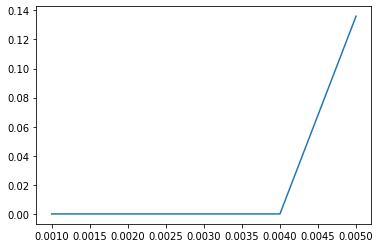

In [44]:
plt.plot(probs, infected_nodes / 1000)